# Use of Measured Aerosol Optical Depth and Precipitable Water to Model Clear Sky Irradiance
*presented at: 2017 IEEE PVSC-44*
*by: Mark A. Mikofski, Clifford W. Hansen, William F. Holmgren and Gregory M. Kimball*

## Introduction
Predicting irradiance is crucial for developing solar power systems. Clear sky models are used to predict irradiance based on solar position and atmospheric data. This paper compares clear sky predictions using atmospheric data from ECMWF with irradiance measurments from SURFRAD. This notebook presents the analysis for the paper and presentation given by the authors at the 2017 IEEE PVSC-44 in Washingtion DC June 25-30th.

## How to use this Jupyter notebook
This document is a [Jupyter notebook](http://jupyter.org/). It can be used several different ways. You can [view the notebook as a static HTML document](http://nbviewer.jupyter.org/github/mikofski/pvsc44-clearsky-aod/blob/master/PVSC-Clearsky-AOD.ipynb). You can also [clone the repository from GitHub using Git](https://github.com/mikofski/pvsc44-clearsky-aod), install [the requirements](https://github.com/mikofski/pvsc44-clearsky-aod/blob/master/requirements.txt) in a [Python virtual environment](https://virtualenv.pypa.io/en/stable/) and run the notebook interactively using [Python](https://www.python.org/).

In [1]:
# imports and settings
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import seaborn as sns
import statsmodels.api as sm

from pvsc44_clearsky_aod import ecmwf_macc_tools

%matplotlib inline

sns.set_context('notebook', rc={'figure.figsize': (16, 8)})

c:\python27\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data
Two sources of data are used in this analysis, SURFRAD and ECMWF, each described in the following sections.

### SURFRAD
SURFRAD data from NOAA contains irradiance measurements at sub-hour increments from seven stations accross the United States. The data can be viewed online or downloaded from a NOAA FTP site <ftp://aftp.cmdl.noaa.gov/data/radiation/surfrad/>. Data is organized folders for each station and yearly subfolders containing individual daily files. The `README` in each station's folder provides additional information such as the format of the files, types of data in each column, definitions, and abbreviations. The first two rows of each daily file contains header information about the file. The first line is the station name and the second line contains the latitude, longitude and elevation.

|station id |UTC offset |timezone   |station name  |latitude |longitude |elevation |
|-----------|-----------|-----------|--------------|---------|----------|----------|
|bon        |-6.0       |US/Central |     Bondville|    40.05|    -88.37|       213|
|tbl        |-7.0       |US/Mountain|Table Mountain|    40.13|   -105.24|      1689|
|dra        |-8.0       |US/Pacific |   Desert Rock|    36.62|   -116.02|      1007|
|fpk        |-7.0       |US/Mountain|     Fort Peck|    48.31|   -105.10|       634|
|gwn        |-6.0       |US/Central | Goodwin Creek|    34.25|    -89.87|        98|
|psu        |-5.0       |US/Eastern |    Penn State|    40.72|    -77.93|       376|
|sxf        |-6.0       |US/Central |   Sioux Falls|    43.73|    -96.62|       473|


In [2]:
# get the "metadata" that contains the timezone, latitude, longitude, elevation and station id for SURFRAD
METADATA = pd.read_csv('metadata.csv', index_col=0)

In [3]:
# get SURFRAD data
station_id = 'tbl'  # choose a station ID from the metadata list

# CONSTANTS
DATADIR = 'surfrad'  # folder where SURFRAD data is stored relative to this file
NA_VAL = '-9999.9'  # value SURFRAD uses for missing data
USECOLS = [0, 6, 7, 8, 9, 10, 11, 12]  # omit 1:year, 2:month, 3:day, 4:hour, 5:minute and 13:jday columns

# read 2003 data for the station, use first column as index, parse index as dates, and replace missing values with NaN
DATA = pd.read_csv(
    os.path.join(DATADIR, '%s03.csv' % station_id),
    index_col=0, usecols=USECOLS, na_values=NA_VAL, parse_dates=True
)

# append the data from 2003 to 2012 which coincides with the ECMWF data available
for y in xrange(2004, 2013):
    DATA = DATA.append(pd.read_csv(
        os.path.join(DATADIR, '%s%s.csv' % (station_id, str(y)[-2:])),
        index_col=0, usecols=USECOLS, na_values=NA_VAL, parse_dates=True
    ))

DATA.index.rename('timestamps', inplace=True)  # rename the index to "timestamps"
# DATA.index = pd.DatetimeIndex(DATA.index)  # since parse_dates=True, timestamps are already parsed, yay!
DATA = DATA.tz_localize('UTC')  # set timezone to UTC
DATA['press'] = DATA['press'] * 100.0  # convert mbars to Pascals
TIMESTEPS = np.diff(np.array(DATA.index, dtype='datetime64[m]'))  # in case we need them

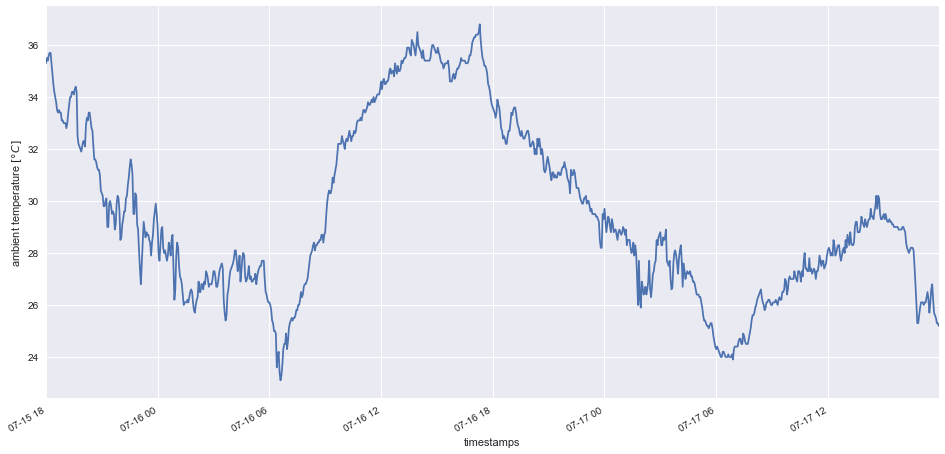

In [4]:
# plot some temperatures
DATA['ta']['2006-07-16':'2006-07-17'].tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('ambient temperature $[\degree C]$')

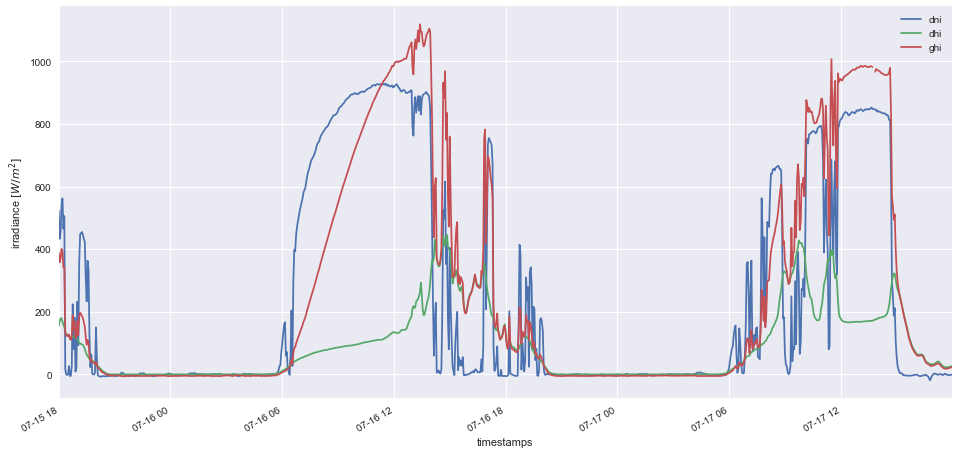

In [5]:
# plot some irradiance
DATA[['dni', 'dhi', 'ghi']]['2006-07-16':'2006-07-17'].tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('irradiance $[W/m^2]$')

### ECMWF
The European Center for Medium Weather Forecast (ECMWF) hosts datasets for the EU Copernicus MACC clearsky model. This data set contains aerosol optical depth (AOD) measured at several wavelengths and total column water vapor (_AKA_: precipitable water) data in centimeters (cm) derived from ground measurments and satelite data for the entire globe from 2003 to 2012. The data can be downloaded from the ECMWF API using the Python API client after registering for an API key. The downloaded data used in this analysis has spatial and temporal resolution of 0.75&deg; x 0.75&deg; and 3-hours.

In [6]:
# get AOD and water vapor for the SURFRAD station
ATMOS = ecmwf_macc_tools.Atmosphere()  # get the downloaded ECMWF-MACC data for the world

# create a datetime series for the ECMWF-MACC data, it's available from 2003 to 2012 in 3 hour increment
TIMES = pd.DatetimeIndex(start='2003-01-01T00:00:00', freq='3H', end='2012-12-31T23:59:59').tz_localize('UTC')

# get the atmospheric data for the SURFRAD station as a pandas dataframe, and append some addition useful calculations
# like AOD at some other wavelengths (380-nm, 500-nm, and 700nm) and convert precipitable water to cm.
STATION_ATM = pd.DataFrame(
    ATMOS.get_all_data(METADATA['latitude'][station_id], METADATA['longitude'][station_id]), index=TIMES
)

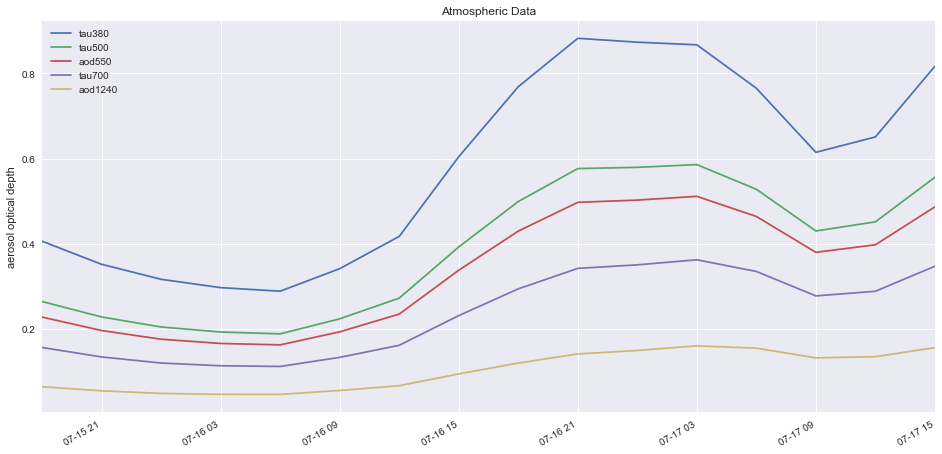

In [7]:
# plot some of the atmospheric data
atm_data = STATION_ATM[['tau380', 'tau500', 'aod550', 'tau700', 'aod1240']]['2006-07-16':'2006-07-17']
atm_data.tz_convert(METADATA['tz'][station_id]).plot()
plt.title('Atmospheric Data')
plt.ylabel('aerosol optical depth')

### Solar Position, Airmass and Precipitable Water
NREL's Solar Position Algorithm (SPA) is used to find solar position including the effects of atmospheric refraction. The path length through the atmosphere or airmass is also calculated. Finally if water vapor measurements are not available, they can be estimated from relative humidity.

In [8]:
# solarposition, airmass, pressure-corrected & water vapor
SOLPOS = pvlib.solarposition.get_solarposition(
    time=DATA.index,
    latitude=METADATA['latitude'][station_id],
    longitude=METADATA['longitude'][station_id],
    altitude=METADATA['elevation'][station_id],
    pressure=DATA['press'],
    temperature=DATA['ta']
)
ZENITH_REFRACTED = SOLPOS.apparent_zenith
AIRMASS = pvlib.atmosphere.relativeairmass(ZENITH_REFRACTED)
AM_PRESS = pvlib.atmosphere.absoluteairmass(AIRMASS, pressure=DATA['press'])
PWAT_CALC = pvlib.atmosphere.gueymard94_pw(DATA['ta'], DATA['rh'])

c:\python27\lib\site-packages\pvlib\atmosphere.py:215: RuntimeWarning: invalid value encountered in power
  0.50572*(((6.07995 + (90 - z)) ** - 1.6364))))
c:\python27\lib\site-packages\pvlib\atmosphere.py:319: RuntimeWarning: invalid value encountered in maximum
  pw = np.maximum(pw, 0.1)


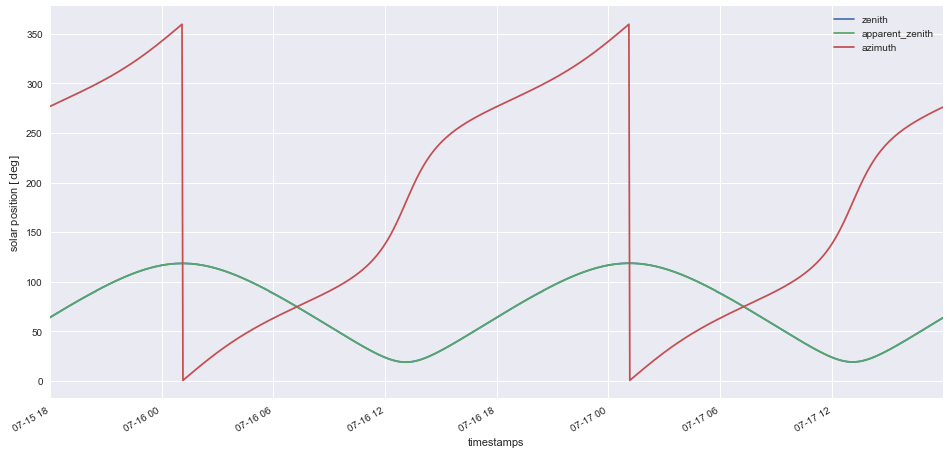

In [9]:
# plot solar position for a day, remember that time is in UTC
SOLPOS[['zenith', 'apparent_zenith', 'azimuth']]['2006-07-16':'2006-07-17'].tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('solar position $[\deg]$')

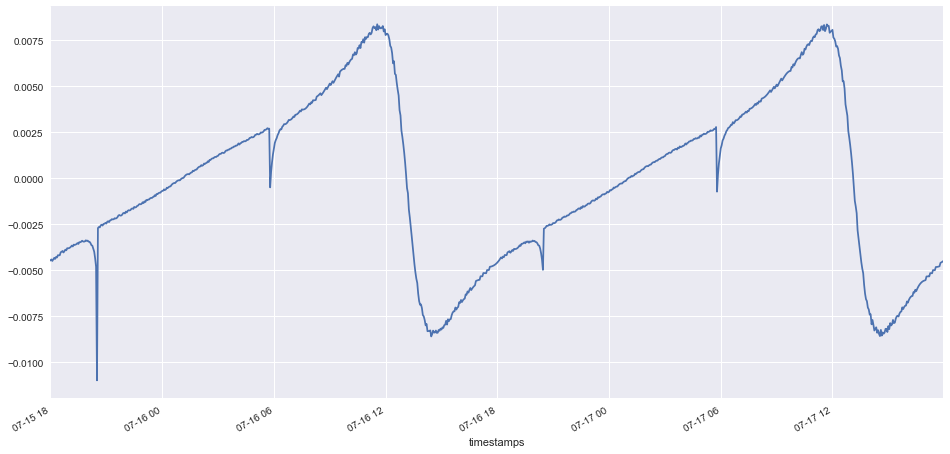

In [10]:
# compare calculated solar position to SURFRAD
(DATA['solzen'] / SOLPOS['apparent_zenith'] - 1)['2006-07-16':'2006-07-17'].tz_convert(METADATA['tz'][station_id]).plot()

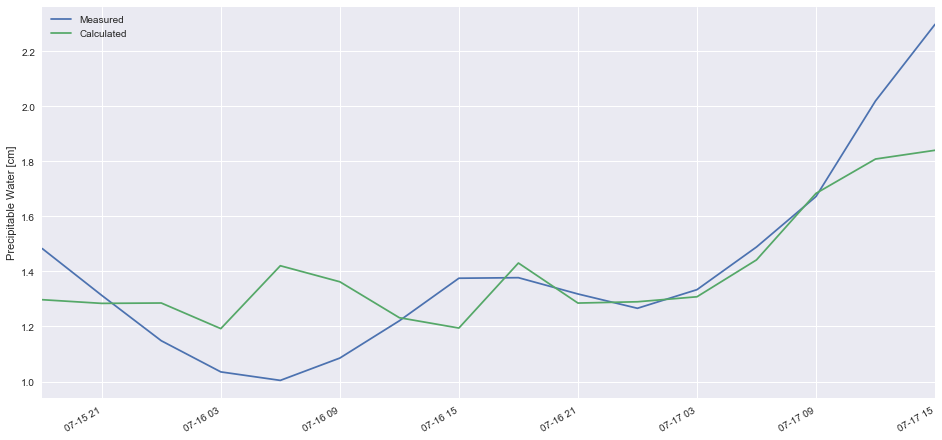

In [11]:
# compare measured and calculated precipitable water
pwat = pd.concat([STATION_ATM['pwat'], PWAT_CALC.resample('3H').mean()], axis=1)
pwat['2006-07-16':'2006-07-17'].tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('Precipitable Water [cm]')
plt.legend(['Measured', 'Calculated'])

### Linke Turbidity
Linke turbidity is an atmospheric parameter that combines AOD and P<sub>wat</sub>. A historical data set from 2003 is used exclusively by the Ineichen clearsky model

In [20]:
# lookup Linke turbidity
LT = pvlib.clearsky.lookup_linke_turbidity(
    time=TIMES,
    latitude=METADATA['latitude'][station_id],
    longitude=METADATA['longitude'][station_id],
)

# calculate Linke turbidity using Kasten pyrheliometric formula
LT_CALC = pvlib.atmosphere.kasten96_lt(
    AM_PRESS, STATION_ATM['pwat'].resample('3min').pad(), STATION_ATM['tau700'].resample('3min').pad()
)

# calculate broadband AOD using Bird & Hulstrom approximation
AOD_CALC = pvlib.atmosphere.bird_hulstrom80_aod_bb(STATION_ATM['tau380'], STATION_ATM['tau500'])

# recalculate Linke turbidity using Bird & Hulstrom broadband AOD
LT_AOD_CALC = pvlib.atmosphere.kasten96_lt(
    AM_PRESS.mean(), STATION_ATM['pwat'].resample('3min').pad(), AOD_CALC.resample('3min').pad()
)

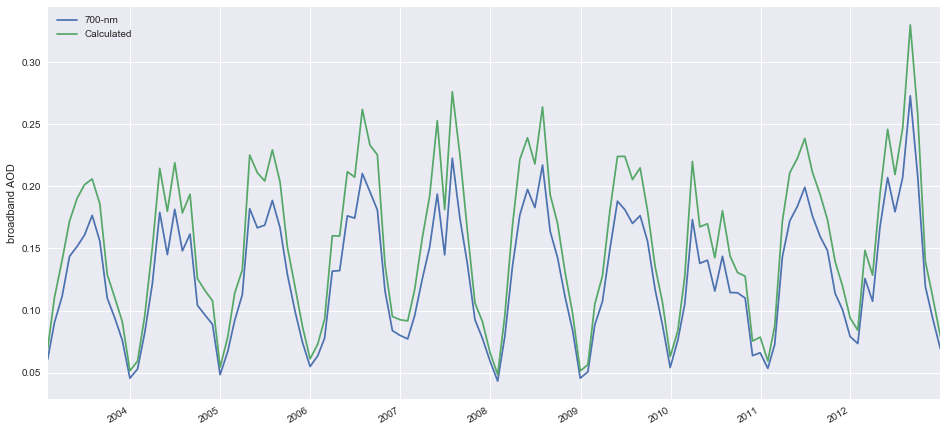

In [21]:
# compare Bird & Hulstrom approximated broadband AOD to AOD at 700-nm
aod_bb = pd.concat([STATION_ATM['tau700'].resample('M').mean(), AOD_CALC.resample('M').mean()], axis=1)
aod_bb.tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('broadband AOD')
plt.legend(['700-nm', 'Calculated'])

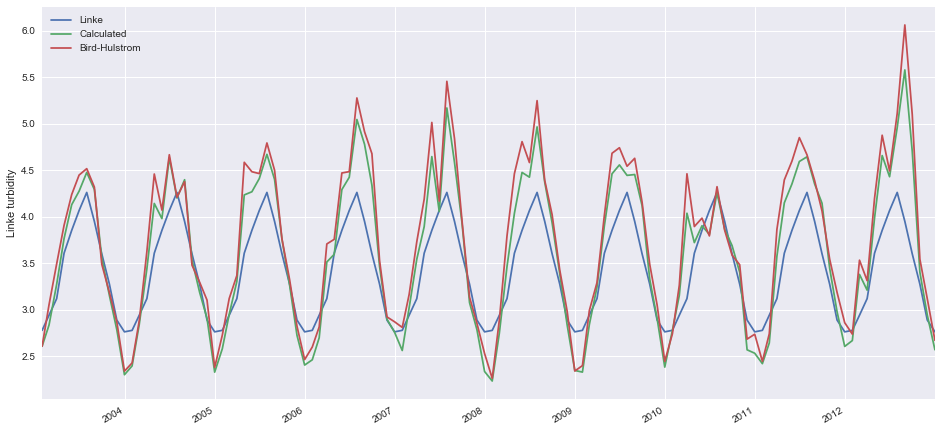

In [22]:
# compare historic Linke turbidity to calculated
pd.concat(
    [LT.resample('M').mean(),
     LT_CALC.resample('M').mean(),
     LT_AOD_CALC.resample('M').mean()],
    axis=1
).tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('Linke turbidity')
plt.legend(['Linke', 'Calculated', 'Bird-Hulstrom'])

In [23]:
# how is atmosphere changing over time?
lt_diff = LT_CALC.resample('A').mean() / LT.resample('A').mean() - 1.0
x = np.arange(lt_diff.size)
x = sm.add_constant(x)
y = lt_diff.values
results = sm.OLS(y, x).fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     3.664
Date:                Tue, 06 Jun 2017   Prob (F-statistic):             0.0920
Time:                        02:07:25   Log-Likelihood:                 20.767
No. Observations:                  10   AIC:                            -37.53
Df Residuals:                       8   BIC:                            -36.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0552      0.020      2.768      0.0

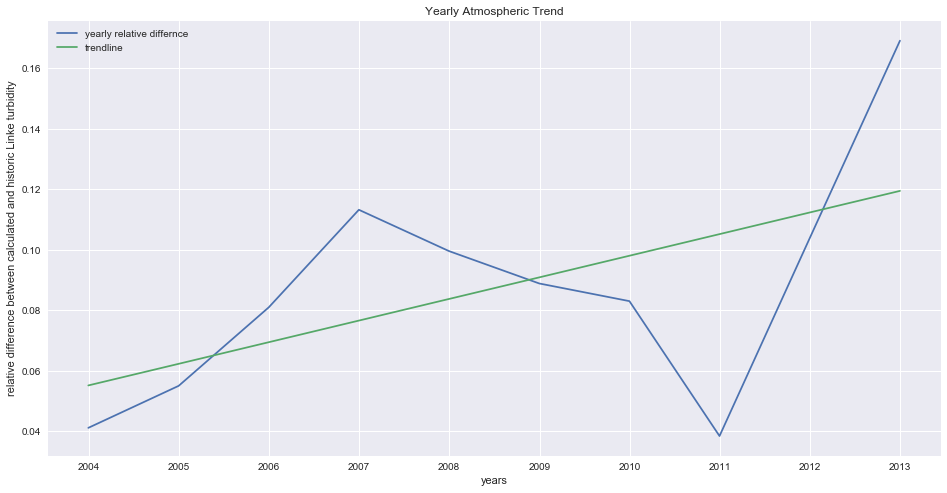

In [24]:
# plot yearly relative difference versus trendline
plt.plot(lt_diff)
plt.plot(lt_diff.index, results.fittedvalues)
plt.title('Yearly Atmospheric Trend')
plt.legend(['yearly relative differnce', 'trendline'])
plt.ylabel('relative difference between calculated and historic Linke turbidity')
plt.xlabel('years')

### Clear sky models
There are several clear sky models, and they take different arguments.

In [25]:
# calculate clear sky
ETR = pvlib.irradiance.extraradiation(DATA.index)
INEICHEN_LT = pvlib.clearsky.ineichen(
    ZENITH_REFRACTED, AM_PRESS, LT.resample('3min').pad(), altitude=METADATA['elevation'][station_id], dni_extra=ETR
)
INEICHEN_CALC = pvlib.clearsky.ineichen(
    ZENITH_REFRACTED, AM_PRESS, LT_CALC.resample('3min').pad(), altitude=METADATA['elevation'][station_id], dni_extra=ETR
)
# SOLIS = pvlib.clearsky.simplified_solis(
#     SOLPOS.apparent_elevation, STATION_ATM['tau700'], STATION_ATM['pwat'],
#     pressure=DATA['press'], dni_extra=ETR
# )
# BIRD = pvlib.clearsky.bird(
#         ZENITH_REFRACTED, AIRMASS, STATION_ATM['tau380'], STATION_ATM['tau500'], STATION_ATM['pwat'],
#         pressure=DATA['press'], dni_extra=ETR
# )

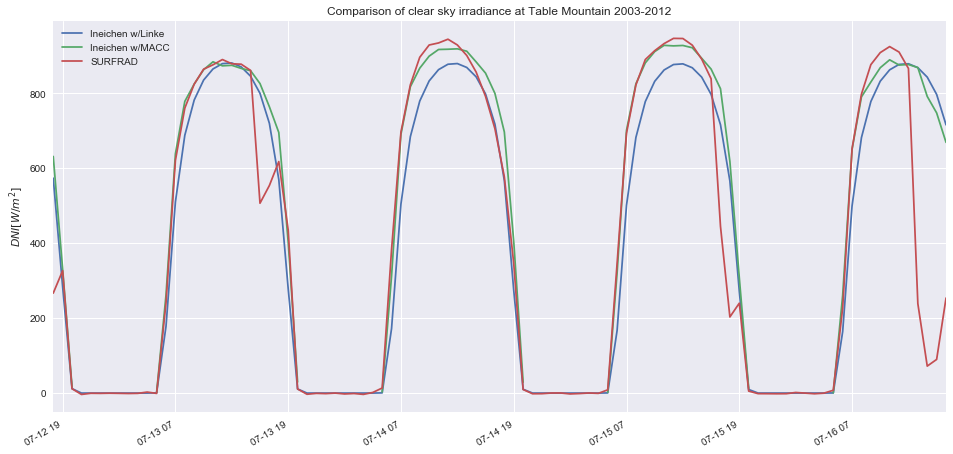

In [33]:
LEGEND = ['Ineichen w/Linke', 'Ineichen w/MACC', 'SURFRAD']
pd.concat([
    INEICHEN_LT['dni'].resample('H').mean(),
    INEICHEN_CALC['dni'].resample('H').mean(),
    DATA['dni'].resample('H').mean()
], axis=1)['2006-07-13':'2006-07-16'].tz_convert(METADATA['tz'][station_id]).plot()
plt.legend(LEGEND)
plt.title('Comparison of clear sky irradiance at %s 2003-2012' % METADATA['station name'][station_id])
plt.ylabel('$DNI [W/m^2]$')

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)
Use of Measured Aerosol Optical Depth and Precipitable Water to Model Clear Sky Irradiance by [Mark A. Mikofski, Clifford W. Hansen, William F. Holmgren and Gregory M. Kimball](https://github.com/mikofski/pvsc44-clearsky-aod) is licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).
